In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import sys
LIBPATH = r'D:\Springboard_DataSci\Assignments\Lib'
if LIBPATH not in sys.path:
    sys.path.insert(0, LIBPATH)
import TimeTracker

TYPE = 'Type'
LOGISTIC = 'logistic'
NAIVE_BAYES = 'multinomial naive Bayes'
RAND_FOREST = 'random forest'

# Get all the tweets.
path = r'D:\Springboard_DataSci\Twitter_MBTI_predictor\Data Output'
os.chdir(path)

In [2]:
letters = [['E', 'I'], ['S', 'N'], ['F', 'T'], ['J', 'P']]
MB_types = []
# Get the list of types using binary math.
for i in range(16):
    MB_types.append(letters[0][i//8%2] + letters[1][i//4%2]
                      + letters[2][i//2%2] + letters[3][i%2])

In [3]:
def load_tweets(MB_type):
    return pd.read_csv(
        path + '\\' + MB_type + '_tweets.csv', parse_dates=[2],
        infer_datetime_format=True)

In [4]:
# Load tweets
print('Loading tweets:', end=' ')
for i, MB_type in enumerate(MB_types):
    print(f'{MB_type}', end=' ')
    if i == 0:
        tweets = load_tweets(MB_type)
    else:
        tweets = tweets.append(load_tweets(MB_type))

Loading tweets: ESFJ ESFP ESTJ ESTP ENFJ ENFP ENTJ ENTP ISFJ ISFP ISTJ ISTP INFJ INFP INTJ INTP 

In [5]:
# Classify their type
for i, letter in enumerate('ESFJ'):
    tweets[letter] = tweets['MBTI'].str[i] == letter

We're going to pick up a lot of junk if we don't trim out tags and hashtags.
Let's do that now.

In [6]:
def trim_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",
                           " ", tweet).split())

In [7]:
print('\nTrimming tweets of tags and URLs')
tweets['Tweet'] = tweets['Tweet'].apply(trim_tweet)


Trimming tweets of tags and URLs


Now let's attempt to classify.

In [8]:
print('Grouping tweets by author')
tweets_per_author = tweets.copy()
tweets_per_author['Tweet'] = tweets_per_author['Tweet']\
    .apply(lambda x: x + ' ')
tweets_per_author = tweets_per_author.groupby(
    tweets_per_author['Screen name'])['Tweet'].apply(lambda x: x.sum())\
    .reset_index()
# This threw away the MBTI info, but we can get it back.
authors_MBTI = tweets[['Screen name', 'E', 'S', 'F', 'J']].drop_duplicates()
tweets_per_author = tweets_per_author.merge(
    authors_MBTI, 'left', on='Screen name')

test_letters = [letter[0] for letter in letters] #for later

Grouping tweets by author


We've looked through several combinations of hyperparameters. Let's look
for the one that performs the best on each axis. We search by axis (letter),
min_df, classifier, and hyperparameter. We look for the best test score per
run and record it. This testing includes random forests, which we have not
looked at yet.

In [9]:
stopwatch = TimeTracker.TimeTracker() # Don't include setup.
for i, test_letter in enumerate(test_letters):
    print(f'\nAnalyzing tweets: {letters[i]}')
    for min_df in [50, 100, 200, 300, 500]:
        print(f'min_df = {min_df}')
        y = tweets_per_author[test_letter]
        vectorizer = CountVectorizer(min_df=min_df)
        X = vectorizer.fit_transform(tweets_per_author['Tweet'].to_list())
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=0)
        
        param_grid = {'alpha': np.power(10., np.arange(-2, 3))}
        grid_search = GridSearchCV(MultinomialNB(), param_grid,
                                   cv=5, return_train_score=True)
        grid_search.fit(X_train, y_train)
        print('\tBest Naive Bayes parameters: {}'.format(
            grid_search.best_params_))
        print('\tBest Naive Bayes CV score: {:.2f}'.format(
            grid_search.best_score_))
        
        param_grid = {'max_depth': [2, 3, 4, 5],
                      'random_state': [0]}
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,
                                    return_train_score=True)
        grid_search.fit(X_train, y_train)
        print('\tBest random forest parameters: {}'.format(
            grid_search.best_params_))
        print('\tBest random forest CV score: {:.2f}'.format(
            grid_search.best_score_))
        
        param_grid = {'C': np.power(10., np.arange(-2, 3)),
                      'max_iter': [1e4], 'random_state': [0]}
        grid_search = GridSearchCV(
            LogisticRegression(), param_grid, cv=5,
            return_train_score=True)
        grid_search.fit(X_train, y_train)
        print('\tBest logistic regression parameters: {}'.format(
            grid_search.best_params_))
        print('\tBest logistic regression CV score: {:.2f}'.format(
            grid_search.best_score_))

print('\aElapsed grid searching time: ' + stopwatch.getElapsedTime())


Analyzing tweets: ['E', 'I']
min_df = 50
	Best Naive Bayes parameters: {'alpha': 10.0}
	Best Naive Bayes CV score: 0.58
	Best random forest parameters: {'max_depth': 5, 'random_state': 0}
	Best random forest CV score: 0.58
	Best logistic regression parameters: {'C': 0.01, 'max_iter': 10000.0, 'random_state': 0}
	Best logistic regression CV score: 0.55
min_df = 100
	Best Naive Bayes parameters: {'alpha': 100.0}
	Best Naive Bayes CV score: 0.58
	Best random forest parameters: {'max_depth': 2, 'random_state': 0}
	Best random forest CV score: 0.57
	Best logistic regression parameters: {'C': 0.01, 'max_iter': 10000.0, 'random_state': 0}
	Best logistic regression CV score: 0.55
min_df = 200
	Best Naive Bayes parameters: {'alpha': 0.01}
	Best Naive Bayes CV score: 0.58
	Best random forest parameters: {'max_depth': 5, 'random_state': 0}
	Best random forest CV score: 0.57
	Best logistic regression parameters: {'C': 0.01, 'max_iter': 10000.0, 'random_state': 0}
	Best logistic regression CV scor

Logistic regressions are by far the slowest of the three classifiers here,
and their scores are slightly worse, so we rule them out. Unlike naive Bayes,
random forests are a "black box" algorithm, whose results are difficult to
explain. In addition, naive Bayes consistently has slightly higher scores, so
we go with that.

The next task is to determine what the optimal value of min_df is. In general,
lower min_df's allow more items in the model but also more overfitting. Seeing
that different values of min_df do not seem to affect the final score too much,
it is a judgment call where to set it. We select a value of 100 to make the
model sufficiently complex while avoiding too much overfitting.

From here we need to select the optimal value of alpha. Their considerable
variation across the optimal results suggests that it may not have much effect
on the model. However, we need to try.

In [10]:
test_size = 0.25
min_df = 100
vectorizer = CountVectorizer(min_df=min_df)
# Get the sparse matrix (x, y) of (tweetID, wordID).
X = vectorizer.fit_transform(tweets_per_author['Tweet'].to_list())
for i, test_letter in enumerate(test_letters):
    print(f'\nSearching optimal alpha: {letters[i]}')
    y = tweets_per_author[test_letter]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0)
    
    best_alpha, best_test_score = None, 0
    for alpha in np.power(10., np.arange(-2, 3)):
        clf = MultinomialNB(alpha=alpha).fit(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        print(f'\tAlpha, test score: {alpha}, {test_score}')
        if test_score > best_test_score:
             best_alpha, best_test_score = alpha, test_score


Searching optimal alpha: ['E', 'I']
	Alpha, test score: 0.01, 0.5975
	Alpha, test score: 0.1, 0.5975
	Alpha, test score: 1.0, 0.595
	Alpha, test score: 10.0, 0.595
	Alpha, test score: 100.0, 0.5925

Searching optimal alpha: ['S', 'N']
	Alpha, test score: 0.01, 0.6625
	Alpha, test score: 0.1, 0.6625
	Alpha, test score: 1.0, 0.6625
	Alpha, test score: 10.0, 0.66
	Alpha, test score: 100.0, 0.66

Searching optimal alpha: ['F', 'T']
	Alpha, test score: 0.01, 0.585
	Alpha, test score: 0.1, 0.585
	Alpha, test score: 1.0, 0.585
	Alpha, test score: 10.0, 0.5875
	Alpha, test score: 100.0, 0.5775

Searching optimal alpha: ['J', 'P']
	Alpha, test score: 0.01, 0.585
	Alpha, test score: 0.1, 0.585
	Alpha, test score: 1.0, 0.5825
	Alpha, test score: 10.0, 0.5875
	Alpha, test score: 100.0, 0.5825


Alpha has very little effect on our test results. Therefore, for each axis,
we select the default of alpha=1.

With our classifier and parameter in place, the final step is to gauge the
probability threshold. Ideally it should be close to 0.5, but we should test
it just to be sure.

Searching optimal probabilities


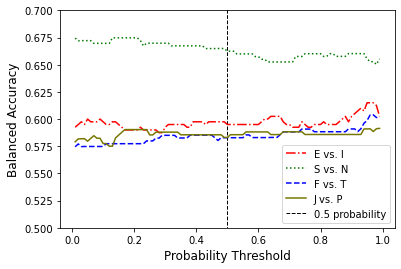

In [11]:
dist_from_half = 0.5
prob_range = np.arange(0.5-dist_from_half, 0.5+dist_from_half+1e-10, 0.01)
test_score = pd.DataFrame(np.empty([prob_range.size, 4]), columns=test_letters)
alpha = 1
print('Searching optimal probabilities')
for i, test_letter in enumerate(test_letters):
    y = tweets_per_author[test_letter]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0)
    
    clf = MultinomialNB(alpha=alpha).fit(X_train, y_train)
    for j, prob in enumerate(prob_range):
        y_pred = clf.predict_proba(X_test)[:,1] > prob
        score = balanced_accuracy_score(y_test, y_pred)
        test_score.iloc[j, i] = score

fig, ax = plt.subplots()
color = ['r', '#007700', 'b', '#777700']
ls = ['-.', ':', '--', '-']
for i, letter in enumerate(test_letters):
    label = f'{letters[i][0]} vs. {letters[i][1]}'
    ax.plot(prob_range[1:-1], test_score[1:-1][letter], c=color[i], ls=ls[i],
            label=label)
fontsize = 12
ax.set_xlabel('Probability Threshold', fontsize=fontsize)
ax.set_ylabel('Balanced Accuracy', fontsize=fontsize)
ax.vlines(0.5, 0, 1, colors=['k'], lw=1, ls='--', label='0.5 probability')
ax.set_ylim(0.5, 0.7)
ax.legend(loc='lower right')

The probability threshold does not appear to affect the results much. This
could indicate that a lot of our results are noise. However, the results are
close to 0.6, implying that there may be something worthwhile there and that
additional testing may improve the results. Additionally, the S/N axis shows
accuracies that are clearly higher than the other three. It suggests that
there is a clearer difference in word choice between S's and N's than the other
three axes.